In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from data.instron_tests.processing import process_csv
import pint
import pint_pandas

ureg = pint_pandas.PintType.ureg
ureg.setup_matplotlib()

In [3]:
PLATE_SEPARATION = 45  # mm

In [148]:
def shift_strain(df, strain_threshold):
    # find index of first compressive strain that is > X% to adjust for slack in test specimen
    # the limit is arbitrary based on pre-analyzing and plotting the raw stress/strain data

    # Check if any values are larger than strain_threshold

    df_ = df.copy()
    mask = df_['Compressive strain (Displacement)'] > strain_threshold
    if not mask.any():
        print(
            f"Warning: No values found above strain threshold of {strain_threshold}")
        return df

    idx = df_.index[mask].tolist()[0]
    # adjust all columns to be zeroed at this index
    for col in df_.columns:
        df_[col] = df_[col] - df_[col][idx]

    return df_


def linear_fit(df, x: str, y: str, x_min=None, x_max=None):
    df_ = df.copy()
    x_ = df[x]
    y_ = df[y]

    mask = np.ones_like(x_, dtype=bool)
    if x_min is not None:
        mask &= x_ >= x_min
    if x_max is not None:
        mask &= x_ <= x_max

    x_filtered = x_[mask].pint.magnitude if hasattr(x_, 'pint') else x_
    y_filtered = y_[mask].pint.magnitude if hasattr(x_, 'pint') else y_

    m, b = np.polyfit(x_filtered, y_filtered, 1)

    units = y_.pint.units if hasattr(y_, 'pint') else 1.
    x_interp = x_.pint.magnitude if hasattr(x_, 'pint') else x_
    df_[y + ' (Line Fit)'] = (m*x_interp + b)  # * units

    return df_, (m, b)

In [159]:
dfs = []
metadata = []
dir = './homogeneous_foam_test_data'

for file in Path(dir).rglob('*.csv'):
    if 'clean' not in file.stem:
        continue

    df = pd.read_csv(file, header=[0, 1]).pint.quantify(level=-1)

    strain_threshold = 0.02  # 2%
    df = shift_strain(df, strain_threshold)

    fit_strain_limits = (0.0, 0.1)
    df, (m, b) = linear_fit(df,
                            x='Compressive strain (Displacement)',
                            y='Compressive stress',
                            x_min=fit_strain_limits[0],
                            x_max=fit_strain_limits[1])
    dfs.append(df)

    metadata.append({
        'filename': file.stem,
        'slope': m,
        'intercept': b
    })

In [160]:
dfs[0].dtypes

Time                                     pint[second][float64]
Displacement                         pint[millimeter][float64]
Compressive displacement             pint[millimeter][float64]
Compressive strain (Displacement)       pint[percent][float64]
Compressive stress                   pint[kilopascal][float64]
Force                                    pint[newton][float64]
Compressive stress (Line Fit)                          float64
dtype: object

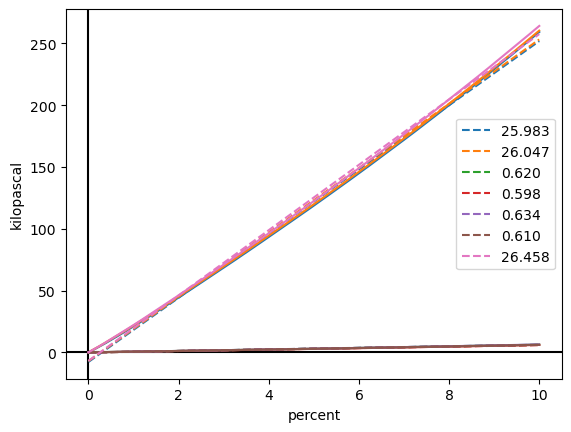

In [161]:
fig, ax = plt.subplots()
ax.axvline(color='k')
ax.axhline(color='k')
x_col = 'Compressive strain (Displacement)'
y1_col = 'Compressive stress'
y2_col = 'Compressive stress (Line Fit)'

xlim = (0, 0.1)

for i, df in enumerate(dfs):
    mask = (df[x_col] >= xlim[0]) & (df[x_col] <= xlim[1])
    ax.plot(df[x_col][mask], df[y1_col][mask])
    ax.plot(df[x_col][mask], df[y2_col][mask],
            linestyle='dashed',
            color=ax.lines[-1].get_color(),
            label=f"{metadata[i]['slope']:.3f}")

ax.legend()

In [7]:
tests = {}
heights = {}
moduli = {}
for file in Path('./homogeneous_foam_test_data').rglob('*.csv'):

    # load
    df = pd.read_csv(file, skiprows=5)
    df.columns = df.columns.map(str) + ' ' + df.iloc[0]
    # df.drop(df.index[0], inplace=True)
    # df = df.astype(float)

    # # find index of first compressive strain that is > X% to adjust for slack in test specimen
    # # the limit is arbitrary based on pre-analyzing and plotting the raw stress/strain data
    # adjust_strain_limit = 2.
    # idx = df.index[df['Compressive strain (Displacement) (%)'] > adjust_strain_limit].tolist()[
    #     0]
    # # adjust all columns to be zeroed at this index
    # for col in df.columns:
    #     df[col] = df[col] - df[col][idx]

    # # linear fit using strain up to 2% (arbitrary limit) using numpy
    # strain_bounds = (0., 1)
    # mask = (df['Compressive strain (Displacement) (%)'] >= strain_bounds[0]) & (
    #     df['Compressive strain (Displacement) (%)'] <= strain_bounds[1])
    # coeffs = np.polyfit(df['Compressive strain (Displacement) (%)']
    #                     [mask], df['Compressive stress (kPa)'][mask], 1)
    # print(coeffs)
    # df['Linear stress fit'] = np.polyval(
    #     coeffs, df['Compressive strain (Displacement) (%)'])

    # tests[file.stem] = df
    print(df.head())

TypeError: can only concatenate str (not "float") to str

(0.00036485118082671923, 100.0)

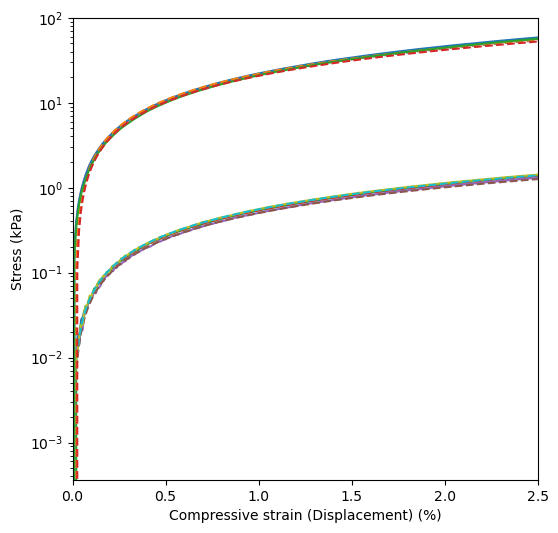

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
for test, data in tests.items():
    # ax.plot(data['Compressive strain (Displacement) (%)'], data['Compressive stress (kPa)'], label=test)
    data.plot(x='Compressive strain (Displacement) (%)',
              y='Compressive stress (kPa)', ax=ax, legend=False)
    data.plot(x='Compressive strain (Displacement) (%)',
              y='Linear stress fit', ax=ax, style='--', legend=False)

ax.set_ylabel('Stress (kPa)')
ax.set_yscale('log')
ax.set_xlim(0, 2.5)
ax.set_ylim(None, 1e2)